In [3]:
# NBVAL_IGNORE_OUTPUT
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov


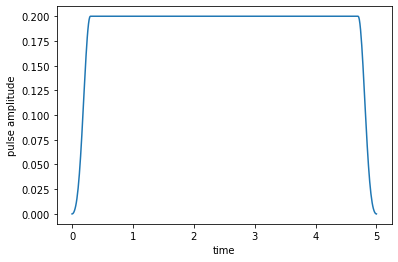

[Objective[ρ₂[2,2] to ρ₃[2,2] via [H₄[2,2], [H₅[2,2], u₃(t)]]]]

In [18]:
def hamiltonian(omega=1.0, ampl0=0.2):
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()

    def guess_control(t, args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
        )

    return [H0, [H1, guess_control]]

H = hamiltonian()

tlist = np.linspace(0, 5, 500)
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)
plot_pulse(H[1][1], tlist)

objectives = [
    krotov.Objective(
        initial_state=qutip.ket2dm(qutip.ket("0")), target=qutip.ket2dm(qutip.ket("1")), H=H, c_ops = []
    )
]

objectives

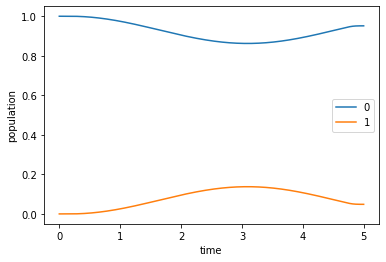

In [19]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='blackman'
    )

pulse_options = {
    H[1][1]: dict(lambda_a=5, update_shape=S)
}

proj0 = qutip.ket2dm(qutip.ket("0"))
proj1 = qutip.ket2dm(qutip.ket("1"))
guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])

def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)
plot_population(guess_dynamics)

In [20]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.DensityMatrixODEPropagator(
        atol=1e-10, rtol=1e-8
    ),
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

ValueError: Incorrect specification of time-dependent Liouvillian

In [7]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2021-04-24 13:00:28
- Number of objectives: 1
- Number of iterations: 18
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2021-04-24 13:01:12 (0:00:44)